# Architektur Neuronales Netz, Output x_H2 und x_NH3

In [1]:
# aNN Architektur

# Importe / Bibliotheken
import torch
from torch import nn
from torch.nn.functional import normalize as norm
from torch import log10
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, MultiStepLR, ReduceLROnPlateau
from sklearn.metrics import r2_score as r2
from sklearn.metrics import max_error
# from sklearn.metrics import mean_squared_error as MSE
# from sklearn.metrics import mean_absolute_error as MAE
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

#### Default Datentyp

In [2]:
torch.set_default_dtype(torch.float64)

#### Erzeugnung des Moduls

In [3]:
class NeuralNetwork(nn.Module):
    
    #Initalisierung der Netzwerk layers
    def __init__(self, input_size, hidden1_size, hidden2_size, hidden3_size, output_size):
    
        super().__init__() #Referenz zur Base Class (nn.Module)
        #Kaskade der Layer
        self.linear_afunc_stack = nn.Sequential(
            #nn.BatchNorm1d(input_size), # Normalisierung, damit Inputdaten gleiche Größenordnung haben
            nn.Linear(input_size, hidden1_size), #Lineare Transformation mit gespeicherten weights und biases
            nn.Tanh(), #Nicht lineare Aktivierungsfunktion um komplexe nichtlineare Zusammenhänge abzubilden
            #nn.SELU(),
            nn.Linear(hidden1_size, hidden2_size),
            nn.Tanh(),
            #nn.SELU(),
            nn.Linear(hidden2_size, hidden3_size),
            nn.Tanh(),
            #nn.SELU(),
            nn.Linear(hidden3_size, output_size),
        )

    #Implementierung der Operationen auf Input Daten
    def forward(self, x):
        out = self.linear_afunc_stack(x)
        return out

#### Ausgabe Modul

In [4]:
model = NeuralNetwork(5, 200, 200, 200, 2)
print(model)

NeuralNetwork(
  (linear_afunc_stack): Sequential(
    (0): Linear(in_features=5, out_features=200, bias=True)
    (1): Tanh()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): Tanh()
    (4): Linear(in_features=200, out_features=200, bias=True)
    (5): Tanh()
    (6): Linear(in_features=200, out_features=2, bias=True)
  )
)


#### DataLoader

In [5]:
batch_size = 32 #Zahl der Datenpaare die vor einem erneuten Update der Parameter ins Netzt gegeben werden
eq_data_file = Path.cwd() / 'data' / 'eq_dataset_x.npz' #Import der GGW Daten

res = np.load(eq_data_file)

# Bei Speicherung wurden Daten als T, p, x_0 und xi gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Outputs x[H2,N2,NH3]
# Umwandlen der np.arrays in torch.tensors zur besseren Arbeit mit PyTorch
T = torch.tensor(res['T'])
p = torch.tensor(res['p'])
x_0 = torch.tensor(res['x_0'])
x = torch.tensor(res['x'])

#Anpassen der Daten auf gleiche Größenordnung
#T = log10(T)
# T = T / 850
# p = p / 1000


# print(T.dtype)
# print(xi.dtype)

x_input = torch.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),1)
y_output = torch.stack((x[:,0], x[:,2]), 1) # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
#print(x_input.size())
# print(xi.size())

# Split des Datensatzes in Trainings und Testdaten
split = 0.8 # Anteil Trainingsdaten

x_input_train = x_input[:int(split * len(x_input)), :]
y_output_train = y_output[:int(split * len(y_output)), :]
x_input_test = x_input[int(split * len(x_input)):, :]
y_output_test = y_output[int(split * len(y_output)):, :]

# Preprocessing Normalisierung der Daten
mean_in = torch.mean(x_input_train,0) # Mittelwert
std_in = torch.std(x_input_train,0) # Standardabweichung
mean_out = torch.mean(y_output_train,0)
std_out = torch.std(y_output_train,0)

x_input_train_norm = (x_input_train - mean_in) / std_in
y_output_train_norm = (y_output_train - mean_out) / std_out

x_input_test_norm = (x_input_test - mean_in) / std_in
y_output_test_norm = (y_output_test - mean_out) / std_out

# print(x_input_train_norm)
# print(torch.mean(x_input_train_norm[:,0]))

# Tensoren zu einem großen Set gruppieren
train_dataset = TensorDataset(x_input_train_norm, y_output_train_norm)
test_dataset = TensorDataset(x_input_test_norm, y_output_test_norm)
    
# # Split in Trainings und Test Set
# train_dataset, test_dataset = random_split(dataset, 
#                                            [int(0.8*len(dataset)), int(0.2*len(dataset))], # splitting 80/20
#                                            generator = torch.Generator().manual_seed(42)) # Festlegung seed zur Reproduktivität

# Erzeugen der DataLoader zur Arbeit mit Daten
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) # shuffle batches zur Reduzierung von overfitting
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)


#### Generierung Netzwerk, Festlegung von loss Funktion und Optimizer

In [6]:
# Erzeugung aNN
net = NeuralNetwork(5, 200, 200, 200, 2)

# Loss Funktion; gibt Fehler an
#loss_fn = nn.MSELoss()
loss_fn = nn.L1Loss()

#Definition custom loss Funktion, MRE
def MRELoss(outputs, targets):
    
    loss = torch.mean(abs((outputs - targets) / targets))
    
    return loss
    

#Optimizer
learning_rate = 1e-2
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
#scheduler = StepLR(optimizer, step_size = 30, gamma = 0.1)
#scheduler = MultiStepLR(optimizer, milestones=[30, 70, 100], gamma = 0.1)
scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 10, threshold = 1e-4)

In [7]:
# learning_rate = 1e-6
# optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate, )

#### Funktion zur Bestimmung der Genauigkeit

In [8]:
def check_accuracy(loader, net):
    
    loss = 0
    MRE = 0
    MAE = 0
    train_correct = 0
    train_total = len(loader.dataset)
    num_batches = len(loader) 
    #train_total = 0
    
    net.eval() # Put network in evaluation mode
    
    if loader == train_dataloader:
        dataset = "Train"
    else:
        dataset = "Test"
    
    with torch.no_grad():
        for X, y in loader:
            pred = net(X)
           
            #loss += MRELoss(pred, y).item()
            loss += loss_fn(pred, y) # Calculate the loss
            MRE += MRELoss(pred * std_out + mean_out, y * std_out + mean_out)
            MAE += loss_fn(pred * std_out + mean_out, y * std_out + mean_out)
            
            # Record the correct predictions for training data
            #_, predictions = torch.max(pred.data, 1)
            for i in range(len(pred)):
                if ((pred[i,0] * std_out[0] + mean_out[0]) - (y[i,0] * std_out[0] + mean_out[0]) and (pred[i,1] * std_out[1] + mean_out[1]) - (y[i,1] * std_out[1] + mean_out[1])) <= 0.01:
                    train_correct += 1
            #train_correct += (abs(pred.argmax(1) - y) <= 0.01).sum().item()
            #train_correct += (abs(predictions - y.data) <= 0.01).sum()
            #train_total += predictions.size(0)
            
        # Genauigkeit berechnen
        acc = float(train_correct) / float(train_total) * 100
        acc = round(acc, 2)
        
        loss /= num_batches
        MRE /= num_batches
        MAE /= num_batches

        print(f"{dataset} Error: \n Accuracy: {acc}%, Avg loss: {loss:>8f}, MRE: {MRE:>8f}, MAE: {MAE:>8f} \n")

    net.train()
    
    return acc, loss, MRE, MAE

#### Training

In [9]:
num_epochs = 200 #Iterationen über Datenset

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
train_MRE = []
test_MRE = []
train_MAE = []
test_MAE = []

#Optimierungsloop
for epoch in range(num_epochs):
#     train_correct = 0
#     train_total = 0
        
    for batch, (X,y) in enumerate(train_dataloader):
        
#         print(X.shape)
#         print(X.dtype)
        
        net.train() #Trainingmodus
        
        # forward
        pred = net(X)  # Do the forward pass
        loss = loss_fn(pred, y) # Calculate the loss
        #loss = MRELoss(pred, y)
        
        # backward
        optimizer.zero_grad() # Clear off the gradients from any past operation
        loss.backward()       # Calculate the gradients with help of back propagation, updating weights and biases
        
        # adam step gradient descent
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients  

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, batch+1, len(train_dataset)//batch_size, loss.item()))
        
    
    #scheduler.step() # Reduzieren Learning Rate (falls step size erreicht)
    net.eval() # Put the network into evaluation mode
    
    # Book keeping    
    # What was our train accuracy?
    tr_acc, tr_loss, tr_MRE, tr_MAE = check_accuracy(train_dataloader, net)
    
    #Record loss and accuracy
    train_accuracy.append(tr_acc)
    train_loss.append(tr_loss)
    train_MRE.append(tr_MRE)
    train_MAE.append(tr_MAE)
    
    scheduler.step(tr_loss) # LR scheduler step für reduceonPlateau
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    t_acc, t_loss, t_MRE, t_MAE = check_accuracy(test_dataloader, net)
    test_accuracy.append(t_acc)
    test_loss.append(t_loss)
    test_MRE.append(t_MRE)
    test_MAE.append(t_MAE)

Epoch 1/200, Iteration 1/25, Loss: 0.9100
Epoch 1/200, Iteration 2/25, Loss: 0.8921
Epoch 1/200, Iteration 3/25, Loss: 1.5445
Epoch 1/200, Iteration 4/25, Loss: 1.1711
Epoch 1/200, Iteration 5/25, Loss: 0.5183
Epoch 1/200, Iteration 6/25, Loss: 0.5408
Epoch 1/200, Iteration 7/25, Loss: 0.7942
Epoch 1/200, Iteration 8/25, Loss: 0.6533
Epoch 1/200, Iteration 9/25, Loss: 0.3777
Epoch 1/200, Iteration 10/25, Loss: 0.4324
Epoch 1/200, Iteration 11/25, Loss: 0.5289
Epoch 1/200, Iteration 12/25, Loss: 0.4641
Epoch 1/200, Iteration 13/25, Loss: 0.4883
Epoch 1/200, Iteration 14/25, Loss: 0.3966
Epoch 1/200, Iteration 15/25, Loss: 0.3524
Epoch 1/200, Iteration 16/25, Loss: 0.3779
Epoch 1/200, Iteration 17/25, Loss: 0.4347
Epoch 1/200, Iteration 18/25, Loss: 0.4190
Epoch 1/200, Iteration 19/25, Loss: 0.4508
Epoch 1/200, Iteration 20/25, Loss: 0.3450
Epoch 1/200, Iteration 21/25, Loss: 0.3547
Epoch 1/200, Iteration 22/25, Loss: 0.4013
Epoch 1/200, Iteration 23/25, Loss: 0.3924
Epoch 1/200, Iterati

Train Error: 
 Accuracy: 88.25%, Avg loss: 0.132718, MRE: 0.113008, MAE: 0.017679 

Test Error: 
 Accuracy: 89.0%, Avg loss: 0.132449, MRE: 0.103882, MAE: 0.017502 

Epoch 8/200, Iteration 1/25, Loss: 0.1364
Epoch 8/200, Iteration 2/25, Loss: 0.1175
Epoch 8/200, Iteration 3/25, Loss: 0.1316
Epoch 8/200, Iteration 4/25, Loss: 0.1354
Epoch 8/200, Iteration 5/25, Loss: 0.1503
Epoch 8/200, Iteration 6/25, Loss: 0.1380
Epoch 8/200, Iteration 7/25, Loss: 0.1549
Epoch 8/200, Iteration 8/25, Loss: 0.1184
Epoch 8/200, Iteration 9/25, Loss: 0.1949
Epoch 8/200, Iteration 10/25, Loss: 0.1762
Epoch 8/200, Iteration 11/25, Loss: 0.1578
Epoch 8/200, Iteration 12/25, Loss: 0.1297
Epoch 8/200, Iteration 13/25, Loss: 0.1942
Epoch 8/200, Iteration 14/25, Loss: 0.1968
Epoch 8/200, Iteration 15/25, Loss: 0.1346
Epoch 8/200, Iteration 16/25, Loss: 0.1538
Epoch 8/200, Iteration 17/25, Loss: 0.1314
Epoch 8/200, Iteration 18/25, Loss: 0.1385
Epoch 8/200, Iteration 19/25, Loss: 0.1976
Epoch 8/200, Iteration 20/

Train Error: 
 Accuracy: 75.25%, Avg loss: 0.170705, MRE: 0.167475, MAE: 0.021442 

Test Error: 
 Accuracy: 79.5%, Avg loss: 0.172127, MRE: 0.143029, MAE: 0.021683 

Epoch 15/200, Iteration 1/25, Loss: 0.1514
Epoch 15/200, Iteration 2/25, Loss: 0.1736
Epoch 15/200, Iteration 3/25, Loss: 0.1357
Epoch 15/200, Iteration 4/25, Loss: 0.1247
Epoch 15/200, Iteration 5/25, Loss: 0.1661
Epoch 15/200, Iteration 6/25, Loss: 0.1251
Epoch 15/200, Iteration 7/25, Loss: 0.2103
Epoch 15/200, Iteration 8/25, Loss: 0.1764
Epoch 15/200, Iteration 9/25, Loss: 0.2321
Epoch 15/200, Iteration 10/25, Loss: 0.1800
Epoch 15/200, Iteration 11/25, Loss: 0.1870
Epoch 15/200, Iteration 12/25, Loss: 0.2426
Epoch 15/200, Iteration 13/25, Loss: 0.2180
Epoch 15/200, Iteration 14/25, Loss: 0.2500
Epoch 15/200, Iteration 15/25, Loss: 0.2575
Epoch 15/200, Iteration 16/25, Loss: 0.2153
Epoch 15/200, Iteration 17/25, Loss: 0.2625
Epoch 15/200, Iteration 18/25, Loss: 0.2302
Epoch 15/200, Iteration 19/25, Loss: 0.2252
Epoch 1

Train Error: 
 Accuracy: 92.25%, Avg loss: 0.045152, MRE: 0.041577, MAE: 0.005767 

Test Error: 
 Accuracy: 88.5%, Avg loss: 0.048481, MRE: 0.038113, MAE: 0.006056 

Epoch 22/200, Iteration 1/25, Loss: 0.0446
Epoch 22/200, Iteration 2/25, Loss: 0.0339
Epoch 22/200, Iteration 3/25, Loss: 0.0403
Epoch 22/200, Iteration 4/25, Loss: 0.0426
Epoch 22/200, Iteration 5/25, Loss: 0.0455
Epoch 22/200, Iteration 6/25, Loss: 0.0386
Epoch 22/200, Iteration 7/25, Loss: 0.0428
Epoch 22/200, Iteration 8/25, Loss: 0.0432
Epoch 22/200, Iteration 9/25, Loss: 0.0436
Epoch 22/200, Iteration 10/25, Loss: 0.0492
Epoch 22/200, Iteration 11/25, Loss: 0.0391
Epoch 22/200, Iteration 12/25, Loss: 0.0389
Epoch 22/200, Iteration 13/25, Loss: 0.0375
Epoch 22/200, Iteration 14/25, Loss: 0.0423
Epoch 22/200, Iteration 15/25, Loss: 0.0450
Epoch 22/200, Iteration 16/25, Loss: 0.0562
Epoch 22/200, Iteration 17/25, Loss: 0.0370
Epoch 22/200, Iteration 18/25, Loss: 0.0365
Epoch 22/200, Iteration 19/25, Loss: 0.0565
Epoch 2

Train Error: 
 Accuracy: 97.75%, Avg loss: 0.026026, MRE: 0.021498, MAE: 0.003446 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.030926, MRE: 0.020944, MAE: 0.003954 

Epoch 29/200, Iteration 1/25, Loss: 0.0192
Epoch 29/200, Iteration 2/25, Loss: 0.0229
Epoch 29/200, Iteration 3/25, Loss: 0.0247
Epoch 29/200, Iteration 4/25, Loss: 0.0228
Epoch 29/200, Iteration 5/25, Loss: 0.0303
Epoch 29/200, Iteration 6/25, Loss: 0.0287
Epoch 29/200, Iteration 7/25, Loss: 0.0336
Epoch 29/200, Iteration 8/25, Loss: 0.0271
Epoch 29/200, Iteration 9/25, Loss: 0.0241
Epoch 29/200, Iteration 10/25, Loss: 0.0276
Epoch 29/200, Iteration 11/25, Loss: 0.0268
Epoch 29/200, Iteration 12/25, Loss: 0.0341
Epoch 29/200, Iteration 13/25, Loss: 0.0301
Epoch 29/200, Iteration 14/25, Loss: 0.0292
Epoch 29/200, Iteration 15/25, Loss: 0.0232
Epoch 29/200, Iteration 16/25, Loss: 0.0360
Epoch 29/200, Iteration 17/25, Loss: 0.0370
Epoch 29/200, Iteration 18/25, Loss: 0.0291
Epoch 29/200, Iteration 19/25, Loss: 0.0225
Epoch 2

Train Error: 
 Accuracy: 98.62%, Avg loss: 0.024842, MRE: 0.019123, MAE: 0.003180 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.030082, MRE: 0.019456, MAE: 0.003851 

Epoch 36/200, Iteration 1/25, Loss: 0.0242
Epoch 36/200, Iteration 2/25, Loss: 0.0255
Epoch 36/200, Iteration 3/25, Loss: 0.0300
Epoch 36/200, Iteration 4/25, Loss: 0.0179
Epoch 36/200, Iteration 5/25, Loss: 0.0272
Epoch 36/200, Iteration 6/25, Loss: 0.0295
Epoch 36/200, Iteration 7/25, Loss: 0.0216
Epoch 36/200, Iteration 8/25, Loss: 0.0241
Epoch 36/200, Iteration 9/25, Loss: 0.0177
Epoch 36/200, Iteration 10/25, Loss: 0.0210
Epoch 36/200, Iteration 11/25, Loss: 0.0230
Epoch 36/200, Iteration 12/25, Loss: 0.0195
Epoch 36/200, Iteration 13/25, Loss: 0.0188
Epoch 36/200, Iteration 14/25, Loss: 0.0241
Epoch 36/200, Iteration 15/25, Loss: 0.0264
Epoch 36/200, Iteration 16/25, Loss: 0.0238
Epoch 36/200, Iteration 17/25, Loss: 0.0220
Epoch 36/200, Iteration 18/25, Loss: 0.0215
Epoch 36/200, Iteration 19/25, Loss: 0.0259
Epoch 3

Train Error: 
 Accuracy: 99.62%, Avg loss: 0.023122, MRE: 0.018568, MAE: 0.002879 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.028535, MRE: 0.019308, MAE: 0.003554 

Epoch 43/200, Iteration 1/25, Loss: 0.0226
Epoch 43/200, Iteration 2/25, Loss: 0.0199
Epoch 43/200, Iteration 3/25, Loss: 0.0241
Epoch 43/200, Iteration 4/25, Loss: 0.0285
Epoch 43/200, Iteration 5/25, Loss: 0.0229
Epoch 43/200, Iteration 6/25, Loss: 0.0179
Epoch 43/200, Iteration 7/25, Loss: 0.0269
Epoch 43/200, Iteration 8/25, Loss: 0.0341
Epoch 43/200, Iteration 9/25, Loss: 0.0245
Epoch 43/200, Iteration 10/25, Loss: 0.0256
Epoch 43/200, Iteration 11/25, Loss: 0.0268
Epoch 43/200, Iteration 12/25, Loss: 0.0188
Epoch 43/200, Iteration 13/25, Loss: 0.0198
Epoch 43/200, Iteration 14/25, Loss: 0.0243
Epoch 43/200, Iteration 15/25, Loss: 0.0239
Epoch 43/200, Iteration 16/25, Loss: 0.0280
Epoch 43/200, Iteration 17/25, Loss: 0.0352
Epoch 43/200, Iteration 18/25, Loss: 0.0278
Epoch 43/200, Iteration 19/25, Loss: 0.0264
Epoch 4

Train Error: 
 Accuracy: 99.62%, Avg loss: 0.029820, MRE: 0.021338, MAE: 0.004636 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.031667, MRE: 0.019778, MAE: 0.004648 

Epoch 50/200, Iteration 1/25, Loss: 0.0287
Epoch 50/200, Iteration 2/25, Loss: 0.0273
Epoch 50/200, Iteration 3/25, Loss: 0.0178
Epoch 50/200, Iteration 4/25, Loss: 0.0252
Epoch 50/200, Iteration 5/25, Loss: 0.0284
Epoch 50/200, Iteration 6/25, Loss: 0.0305
Epoch 50/200, Iteration 7/25, Loss: 0.0240
Epoch 50/200, Iteration 8/25, Loss: 0.0302
Epoch 50/200, Iteration 9/25, Loss: 0.0362
Epoch 50/200, Iteration 10/25, Loss: 0.0244
Epoch 50/200, Iteration 11/25, Loss: 0.0267
Epoch 50/200, Iteration 12/25, Loss: 0.0288
Epoch 50/200, Iteration 13/25, Loss: 0.0279
Epoch 50/200, Iteration 14/25, Loss: 0.0177
Epoch 50/200, Iteration 15/25, Loss: 0.0209
Epoch 50/200, Iteration 16/25, Loss: 0.0393
Epoch 50/200, Iteration 17/25, Loss: 0.0257
Epoch 50/200, Iteration 18/25, Loss: 0.0197
Epoch 50/200, Iteration 19/25, Loss: 0.0332
Epoch 5

Train Error: 
 Accuracy: 99.62%, Avg loss: 0.009312, MRE: 0.008725, MAE: 0.001232 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.017894, MRE: 0.011856, MAE: 0.002261 

Epoch 57/200, Iteration 1/25, Loss: 0.0084
Epoch 57/200, Iteration 2/25, Loss: 0.0080
Epoch 57/200, Iteration 3/25, Loss: 0.0088
Epoch 57/200, Iteration 4/25, Loss: 0.0110
Epoch 57/200, Iteration 5/25, Loss: 0.0079
Epoch 57/200, Iteration 6/25, Loss: 0.0078
Epoch 57/200, Iteration 7/25, Loss: 0.0089
Epoch 57/200, Iteration 8/25, Loss: 0.0103
Epoch 57/200, Iteration 9/25, Loss: 0.0092
Epoch 57/200, Iteration 10/25, Loss: 0.0102
Epoch 57/200, Iteration 11/25, Loss: 0.0086
Epoch 57/200, Iteration 12/25, Loss: 0.0079
Epoch 57/200, Iteration 13/25, Loss: 0.0087
Epoch 57/200, Iteration 14/25, Loss: 0.0103
Epoch 57/200, Iteration 15/25, Loss: 0.0093
Epoch 57/200, Iteration 16/25, Loss: 0.0095
Epoch 57/200, Iteration 17/25, Loss: 0.0086
Epoch 57/200, Iteration 18/25, Loss: 0.0066
Epoch 57/200, Iteration 19/25, Loss: 0.0122
Epoch 

Train Error: 
 Accuracy: 99.62%, Avg loss: 0.008072, MRE: 0.007600, MAE: 0.001058 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.016796, MRE: 0.010913, MAE: 0.002113 

Epoch 64/200, Iteration 1/25, Loss: 0.0073
Epoch 64/200, Iteration 2/25, Loss: 0.0097
Epoch 64/200, Iteration 3/25, Loss: 0.0088
Epoch 64/200, Iteration 4/25, Loss: 0.0076
Epoch 64/200, Iteration 5/25, Loss: 0.0096
Epoch 64/200, Iteration 6/25, Loss: 0.0090
Epoch 64/200, Iteration 7/25, Loss: 0.0077
Epoch 64/200, Iteration 8/25, Loss: 0.0083
Epoch 64/200, Iteration 9/25, Loss: 0.0082
Epoch 64/200, Iteration 10/25, Loss: 0.0087
Epoch 64/200, Iteration 11/25, Loss: 0.0067
Epoch 64/200, Iteration 12/25, Loss: 0.0088
Epoch 64/200, Iteration 13/25, Loss: 0.0069
Epoch 64/200, Iteration 14/25, Loss: 0.0078
Epoch 64/200, Iteration 15/25, Loss: 0.0078
Epoch 64/200, Iteration 16/25, Loss: 0.0073
Epoch 64/200, Iteration 17/25, Loss: 0.0109
Epoch 64/200, Iteration 18/25, Loss: 0.0093
Epoch 64/200, Iteration 19/25, Loss: 0.0105
Epoch 6

Epoch 70/200, Iteration 22/25, Loss: 0.0098
Epoch 70/200, Iteration 23/25, Loss: 0.0073
Epoch 70/200, Iteration 24/25, Loss: 0.0082
Epoch 70/200, Iteration 25/25, Loss: 0.0113
Train Error: 
 Accuracy: 99.62%, Avg loss: 0.007890, MRE: 0.007444, MAE: 0.001065 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.016463, MRE: 0.010950, MAE: 0.002077 

Epoch 71/200, Iteration 1/25, Loss: 0.0095
Epoch 71/200, Iteration 2/25, Loss: 0.0064
Epoch 71/200, Iteration 3/25, Loss: 0.0085
Epoch 71/200, Iteration 4/25, Loss: 0.0067
Epoch 71/200, Iteration 5/25, Loss: 0.0085
Epoch 71/200, Iteration 6/25, Loss: 0.0070
Epoch 71/200, Iteration 7/25, Loss: 0.0079
Epoch 71/200, Iteration 8/25, Loss: 0.0068
Epoch 71/200, Iteration 9/25, Loss: 0.0101
Epoch 71/200, Iteration 10/25, Loss: 0.0062
Epoch 71/200, Iteration 11/25, Loss: 0.0056
Epoch 71/200, Iteration 12/25, Loss: 0.0069
Epoch 71/200, Iteration 13/25, Loss: 0.0083
Epoch 71/200, Iteration 14/25, Loss: 0.0123
Epoch 71/200, Iteration 15/25, Loss: 0.0084
Epoch 

Epoch 77/200, Iteration 24/25, Loss: 0.0068
Epoch 77/200, Iteration 25/25, Loss: 0.0064
Train Error: 
 Accuracy: 99.62%, Avg loss: 0.007635, MRE: 0.007118, MAE: 0.001023 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.015986, MRE: 0.010511, MAE: 0.002028 

Epoch 78/200, Iteration 1/25, Loss: 0.0063
Epoch 78/200, Iteration 2/25, Loss: 0.0062
Epoch 78/200, Iteration 3/25, Loss: 0.0066
Epoch 78/200, Iteration 4/25, Loss: 0.0073
Epoch 78/200, Iteration 5/25, Loss: 0.0079
Epoch 78/200, Iteration 6/25, Loss: 0.0060
Epoch 78/200, Iteration 7/25, Loss: 0.0069
Epoch 78/200, Iteration 8/25, Loss: 0.0082
Epoch 78/200, Iteration 9/25, Loss: 0.0118
Epoch 78/200, Iteration 10/25, Loss: 0.0082
Epoch 78/200, Iteration 11/25, Loss: 0.0067
Epoch 78/200, Iteration 12/25, Loss: 0.0071
Epoch 78/200, Iteration 13/25, Loss: 0.0068
Epoch 78/200, Iteration 14/25, Loss: 0.0069
Epoch 78/200, Iteration 15/25, Loss: 0.0067
Epoch 78/200, Iteration 16/25, Loss: 0.0070
Epoch 78/200, Iteration 17/25, Loss: 0.0073
Epoch 

Epoch 84/200, Iteration 25/25, Loss: 0.0064
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.007237, MRE: 0.006752, MAE: 0.000927 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.015197, MRE: 0.010173, MAE: 0.001913 

Epoch 85/200, Iteration 1/25, Loss: 0.0063
Epoch 85/200, Iteration 2/25, Loss: 0.0078
Epoch 85/200, Iteration 3/25, Loss: 0.0073
Epoch 85/200, Iteration 4/25, Loss: 0.0080
Epoch 85/200, Iteration 5/25, Loss: 0.0069
Epoch 85/200, Iteration 6/25, Loss: 0.0065
Epoch 85/200, Iteration 7/25, Loss: 0.0076
Epoch 85/200, Iteration 8/25, Loss: 0.0065
Epoch 85/200, Iteration 9/25, Loss: 0.0051
Epoch 85/200, Iteration 10/25, Loss: 0.0101
Epoch 85/200, Iteration 11/25, Loss: 0.0091
Epoch 85/200, Iteration 12/25, Loss: 0.0091
Epoch 85/200, Iteration 13/25, Loss: 0.0070
Epoch 85/200, Iteration 14/25, Loss: 0.0102
Epoch 85/200, Iteration 15/25, Loss: 0.0058
Epoch 85/200, Iteration 16/25, Loss: 0.0081
Epoch 85/200, Iteration 17/25, Loss: 0.0071
Epoch 85/200, Iteration 18/25, Loss: 0.0059
Epoch 

Train Error: 
 Accuracy: 99.88%, Avg loss: 0.006524, MRE: 0.006248, MAE: 0.000865 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.015174, MRE: 0.009829, MAE: 0.001911 

Epoch 92/200, Iteration 1/25, Loss: 0.0066
Epoch 92/200, Iteration 2/25, Loss: 0.0067
Epoch 92/200, Iteration 3/25, Loss: 0.0065
Epoch 92/200, Iteration 4/25, Loss: 0.0063
Epoch 92/200, Iteration 5/25, Loss: 0.0061
Epoch 92/200, Iteration 6/25, Loss: 0.0067
Epoch 92/200, Iteration 7/25, Loss: 0.0062
Epoch 92/200, Iteration 8/25, Loss: 0.0084
Epoch 92/200, Iteration 9/25, Loss: 0.0054
Epoch 92/200, Iteration 10/25, Loss: 0.0075
Epoch 92/200, Iteration 11/25, Loss: 0.0069
Epoch 92/200, Iteration 12/25, Loss: 0.0099
Epoch 92/200, Iteration 13/25, Loss: 0.0061
Epoch 92/200, Iteration 14/25, Loss: 0.0090
Epoch 92/200, Iteration 15/25, Loss: 0.0056
Epoch 92/200, Iteration 16/25, Loss: 0.0051
Epoch 92/200, Iteration 17/25, Loss: 0.0069
Epoch 92/200, Iteration 18/25, Loss: 0.0092
Epoch 92/200, Iteration 19/25, Loss: 0.0073
Epoch 

Epoch 98/200, Iteration 13/25, Loss: 0.0059
Epoch 98/200, Iteration 14/25, Loss: 0.0065
Epoch 98/200, Iteration 15/25, Loss: 0.0062
Epoch 98/200, Iteration 16/25, Loss: 0.0062
Epoch 98/200, Iteration 17/25, Loss: 0.0060
Epoch 98/200, Iteration 18/25, Loss: 0.0071
Epoch 98/200, Iteration 19/25, Loss: 0.0076
Epoch 98/200, Iteration 20/25, Loss: 0.0064
Epoch 98/200, Iteration 21/25, Loss: 0.0056
Epoch 98/200, Iteration 22/25, Loss: 0.0059
Epoch 98/200, Iteration 23/25, Loss: 0.0085
Epoch 98/200, Iteration 24/25, Loss: 0.0055
Epoch 98/200, Iteration 25/25, Loss: 0.0082
Train Error: 
 Accuracy: 99.88%, Avg loss: 0.006883, MRE: 0.006430, MAE: 0.000925 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.014622, MRE: 0.009697, MAE: 0.001856 

Epoch 99/200, Iteration 1/25, Loss: 0.0059
Epoch 99/200, Iteration 2/25, Loss: 0.0053
Epoch 99/200, Iteration 3/25, Loss: 0.0061
Epoch 99/200, Iteration 4/25, Loss: 0.0055
Epoch 99/200, Iteration 5/25, Loss: 0.0074
Epoch 99/200, Iteration 6/25, Loss: 0.0056
Epo

Train Error: 
 Accuracy: 99.88%, Avg loss: 0.005993, MRE: 0.005941, MAE: 0.000791 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.014499, MRE: 0.009131, MAE: 0.001824 

Epoch 105/200, Iteration 1/25, Loss: 0.0072
Epoch 105/200, Iteration 2/25, Loss: 0.0072
Epoch 105/200, Iteration 3/25, Loss: 0.0058
Epoch 105/200, Iteration 4/25, Loss: 0.0070
Epoch 105/200, Iteration 5/25, Loss: 0.0051
Epoch 105/200, Iteration 6/25, Loss: 0.0058
Epoch 105/200, Iteration 7/25, Loss: 0.0062
Epoch 105/200, Iteration 8/25, Loss: 0.0065
Epoch 105/200, Iteration 9/25, Loss: 0.0062
Epoch 105/200, Iteration 10/25, Loss: 0.0044
Epoch 105/200, Iteration 11/25, Loss: 0.0051
Epoch 105/200, Iteration 12/25, Loss: 0.0055
Epoch 105/200, Iteration 13/25, Loss: 0.0056
Epoch 105/200, Iteration 14/25, Loss: 0.0067
Epoch 105/200, Iteration 15/25, Loss: 0.0072
Epoch 105/200, Iteration 16/25, Loss: 0.0054
Epoch 105/200, Iteration 17/25, Loss: 0.0066
Epoch 105/200, Iteration 18/25, Loss: 0.0064
Epoch 105/200, Iteration 19/25, 

Epoch 111/200, Iteration 10/25, Loss: 0.0063
Epoch 111/200, Iteration 11/25, Loss: 0.0054
Epoch 111/200, Iteration 12/25, Loss: 0.0051
Epoch 111/200, Iteration 13/25, Loss: 0.0056
Epoch 111/200, Iteration 14/25, Loss: 0.0092
Epoch 111/200, Iteration 15/25, Loss: 0.0051
Epoch 111/200, Iteration 16/25, Loss: 0.0067
Epoch 111/200, Iteration 17/25, Loss: 0.0059
Epoch 111/200, Iteration 18/25, Loss: 0.0052
Epoch 111/200, Iteration 19/25, Loss: 0.0070
Epoch 111/200, Iteration 20/25, Loss: 0.0070
Epoch 111/200, Iteration 21/25, Loss: 0.0058
Epoch 111/200, Iteration 22/25, Loss: 0.0101
Epoch 111/200, Iteration 23/25, Loss: 0.0084
Epoch 111/200, Iteration 24/25, Loss: 0.0061
Epoch 111/200, Iteration 25/25, Loss: 0.0054
Train Error: 
 Accuracy: 99.88%, Avg loss: 0.006673, MRE: 0.007037, MAE: 0.000894 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.014427, MRE: 0.009157, MAE: 0.001837 

Epoch 112/200, Iteration 1/25, Loss: 0.0074
Epoch 112/200, Iteration 2/25, Loss: 0.0057
Epoch 112/200, Iteration 

Train Error: 
 Accuracy: 99.88%, Avg loss: 0.006063, MRE: 0.006010, MAE: 0.000811 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.014362, MRE: 0.009433, MAE: 0.001792 

Epoch 118/200, Iteration 1/25, Loss: 0.0053
Epoch 118/200, Iteration 2/25, Loss: 0.0053
Epoch 118/200, Iteration 3/25, Loss: 0.0047
Epoch 118/200, Iteration 4/25, Loss: 0.0053
Epoch 118/200, Iteration 5/25, Loss: 0.0053
Epoch 118/200, Iteration 6/25, Loss: 0.0132
Epoch 118/200, Iteration 7/25, Loss: 0.0073
Epoch 118/200, Iteration 8/25, Loss: 0.0090
Epoch 118/200, Iteration 9/25, Loss: 0.0062
Epoch 118/200, Iteration 10/25, Loss: 0.0047
Epoch 118/200, Iteration 11/25, Loss: 0.0056
Epoch 118/200, Iteration 12/25, Loss: 0.0044
Epoch 118/200, Iteration 13/25, Loss: 0.0062
Epoch 118/200, Iteration 14/25, Loss: 0.0074
Epoch 118/200, Iteration 15/25, Loss: 0.0050
Epoch 118/200, Iteration 16/25, Loss: 0.0056
Epoch 118/200, Iteration 17/25, Loss: 0.0057
Epoch 118/200, Iteration 18/25, Loss: 0.0068
Epoch 118/200, Iteration 19/25, 

Epoch 124/200, Iteration 19/25, Loss: 0.0069
Epoch 124/200, Iteration 20/25, Loss: 0.0049
Epoch 124/200, Iteration 21/25, Loss: 0.0057
Epoch 124/200, Iteration 22/25, Loss: 0.0064
Epoch 124/200, Iteration 23/25, Loss: 0.0053
Epoch 124/200, Iteration 24/25, Loss: 0.0056
Epoch 124/200, Iteration 25/25, Loss: 0.0102
Train Error: 
 Accuracy: 99.88%, Avg loss: 0.005853, MRE: 0.005585, MAE: 0.000804 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.014045, MRE: 0.008925, MAE: 0.001791 

Epoch 125/200, Iteration 1/25, Loss: 0.0067
Epoch 125/200, Iteration 2/25, Loss: 0.0047
Epoch 125/200, Iteration 3/25, Loss: 0.0060
Epoch 125/200, Iteration 4/25, Loss: 0.0057
Epoch 125/200, Iteration 5/25, Loss: 0.0081
Epoch 125/200, Iteration 6/25, Loss: 0.0063
Epoch 125/200, Iteration 7/25, Loss: 0.0061
Epoch 125/200, Iteration 8/25, Loss: 0.0069
Epoch 125/200, Iteration 9/25, Loss: 0.0055
Epoch 125/200, Iteration 10/25, Loss: 0.0082
Epoch 125/200, Iteration 11/25, Loss: 0.0057
Epoch 125/200, Iteration 12/25, 

Epoch 131/200, Iteration 14/25, Loss: 0.0057
Epoch 131/200, Iteration 15/25, Loss: 0.0061
Epoch 131/200, Iteration 16/25, Loss: 0.0069
Epoch 131/200, Iteration 17/25, Loss: 0.0081
Epoch 131/200, Iteration 18/25, Loss: 0.0050
Epoch 131/200, Iteration 19/25, Loss: 0.0056
Epoch 131/200, Iteration 20/25, Loss: 0.0056
Epoch 131/200, Iteration 21/25, Loss: 0.0058
Epoch 131/200, Iteration 22/25, Loss: 0.0055
Epoch 131/200, Iteration 23/25, Loss: 0.0047
Epoch 131/200, Iteration 24/25, Loss: 0.0069
Epoch 131/200, Iteration 25/25, Loss: 0.0059
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.006110, MRE: 0.005697, MAE: 0.000847 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.013604, MRE: 0.008574, MAE: 0.001728 

Epoch 132/200, Iteration 1/25, Loss: 0.0050
Epoch 132/200, Iteration 2/25, Loss: 0.0072
Epoch 132/200, Iteration 3/25, Loss: 0.0082
Epoch 132/200, Iteration 4/25, Loss: 0.0053
Epoch 132/200, Iteration 5/25, Loss: 0.0069
Epoch 132/200, Iteration 6/25, Loss: 0.0090
Epoch 132/200, Iteration 7/25

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.005107, MRE: 0.005058, MAE: 0.000687 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.013145, MRE: 0.008342, MAE: 0.001674 

Epoch 138/200, Iteration 1/25, Loss: 0.0045
Epoch 138/200, Iteration 2/25, Loss: 0.0056
Epoch 138/200, Iteration 3/25, Loss: 0.0045
Epoch 138/200, Iteration 4/25, Loss: 0.0055
Epoch 138/200, Iteration 5/25, Loss: 0.0057
Epoch 138/200, Iteration 6/25, Loss: 0.0066
Epoch 138/200, Iteration 7/25, Loss: 0.0051
Epoch 138/200, Iteration 8/25, Loss: 0.0044
Epoch 138/200, Iteration 9/25, Loss: 0.0061
Epoch 138/200, Iteration 10/25, Loss: 0.0059
Epoch 138/200, Iteration 11/25, Loss: 0.0049
Epoch 138/200, Iteration 12/25, Loss: 0.0103
Epoch 138/200, Iteration 13/25, Loss: 0.0049
Epoch 138/200, Iteration 14/25, Loss: 0.0077
Epoch 138/200, Iteration 15/25, Loss: 0.0059
Epoch 138/200, Iteration 16/25, Loss: 0.0049
Epoch 138/200, Iteration 17/25, Loss: 0.0051
Epoch 138/200, Iteration 18/25, Loss: 0.0095
Epoch 138/200, Iteration 19/25, 

Epoch 144/200, Iteration 15/25, Loss: 0.0058
Epoch 144/200, Iteration 16/25, Loss: 0.0065
Epoch 144/200, Iteration 17/25, Loss: 0.0059
Epoch 144/200, Iteration 18/25, Loss: 0.0050
Epoch 144/200, Iteration 19/25, Loss: 0.0059
Epoch 144/200, Iteration 20/25, Loss: 0.0067
Epoch 144/200, Iteration 21/25, Loss: 0.0065
Epoch 144/200, Iteration 22/25, Loss: 0.0056
Epoch 144/200, Iteration 23/25, Loss: 0.0112
Epoch 144/200, Iteration 24/25, Loss: 0.0062
Epoch 144/200, Iteration 25/25, Loss: 0.0063
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.005728, MRE: 0.005496, MAE: 0.000759 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.013396, MRE: 0.008498, MAE: 0.001683 

Epoch 145/200, Iteration 1/25, Loss: 0.0051
Epoch 145/200, Iteration 2/25, Loss: 0.0046
Epoch 145/200, Iteration 3/25, Loss: 0.0047
Epoch 145/200, Iteration 4/25, Loss: 0.0065
Epoch 145/200, Iteration 5/25, Loss: 0.0060
Epoch 145/200, Iteration 6/25, Loss: 0.0057
Epoch 145/200, Iteration 7/25, Loss: 0.0045
Epoch 145/200, Iteration 8/25,

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.004454, MRE: 0.004668, MAE: 0.000596 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.013013, MRE: 0.008185, MAE: 0.001646 

Epoch 151/200, Iteration 1/25, Loss: 0.0033
Epoch 151/200, Iteration 2/25, Loss: 0.0036
Epoch 151/200, Iteration 3/25, Loss: 0.0038
Epoch 151/200, Iteration 4/25, Loss: 0.0045
Epoch 151/200, Iteration 5/25, Loss: 0.0032
Epoch 151/200, Iteration 6/25, Loss: 0.0031
Epoch 151/200, Iteration 7/25, Loss: 0.0047
Epoch 151/200, Iteration 8/25, Loss: 0.0041
Epoch 151/200, Iteration 9/25, Loss: 0.0058
Epoch 151/200, Iteration 10/25, Loss: 0.0048
Epoch 151/200, Iteration 11/25, Loss: 0.0052
Epoch 151/200, Iteration 12/25, Loss: 0.0047
Epoch 151/200, Iteration 13/25, Loss: 0.0069
Epoch 151/200, Iteration 14/25, Loss: 0.0041
Epoch 151/200, Iteration 15/25, Loss: 0.0046
Epoch 151/200, Iteration 16/25, Loss: 0.0034
Epoch 151/200, Iteration 17/25, Loss: 0.0045
Epoch 151/200, Iteration 18/25, Loss: 0.0048
Epoch 151/200, Iteration 19/25, 

Epoch 157/200, Iteration 16/25, Loss: 0.0071
Epoch 157/200, Iteration 17/25, Loss: 0.0045
Epoch 157/200, Iteration 18/25, Loss: 0.0041
Epoch 157/200, Iteration 19/25, Loss: 0.0035
Epoch 157/200, Iteration 20/25, Loss: 0.0039
Epoch 157/200, Iteration 21/25, Loss: 0.0041
Epoch 157/200, Iteration 22/25, Loss: 0.0034
Epoch 157/200, Iteration 23/25, Loss: 0.0044
Epoch 157/200, Iteration 24/25, Loss: 0.0029
Epoch 157/200, Iteration 25/25, Loss: 0.0032
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.004145, MRE: 0.004482, MAE: 0.000555 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.012911, MRE: 0.008112, MAE: 0.001631 

Epoch 158/200, Iteration 1/25, Loss: 0.0032
Epoch 158/200, Iteration 2/25, Loss: 0.0039
Epoch 158/200, Iteration 3/25, Loss: 0.0034
Epoch 158/200, Iteration 4/25, Loss: 0.0044
Epoch 158/200, Iteration 5/25, Loss: 0.0032
Epoch 158/200, Iteration 6/25, Loss: 0.0062
Epoch 158/200, Iteration 7/25, Loss: 0.0036
Epoch 158/200, Iteration 8/25, Loss: 0.0031
Epoch 158/200, Iteration 9/25, 

Epoch 164/200, Iteration 16/25, Loss: 0.0036
Epoch 164/200, Iteration 17/25, Loss: 0.0032
Epoch 164/200, Iteration 18/25, Loss: 0.0049
Epoch 164/200, Iteration 19/25, Loss: 0.0049
Epoch 164/200, Iteration 20/25, Loss: 0.0062
Epoch 164/200, Iteration 21/25, Loss: 0.0039
Epoch 164/200, Iteration 22/25, Loss: 0.0052
Epoch 164/200, Iteration 23/25, Loss: 0.0030
Epoch 164/200, Iteration 24/25, Loss: 0.0037
Epoch 164/200, Iteration 25/25, Loss: 0.0042
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.004227, MRE: 0.004459, MAE: 0.000571 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.012988, MRE: 0.008169, MAE: 0.001637 

Epoch 165/200, Iteration 1/25, Loss: 0.0033
Epoch 165/200, Iteration 2/25, Loss: 0.0042
Epoch 165/200, Iteration 3/25, Loss: 0.0054
Epoch 165/200, Iteration 4/25, Loss: 0.0028
Epoch 165/200, Iteration 5/25, Loss: 0.0038
Epoch 165/200, Iteration 6/25, Loss: 0.0031
Epoch 165/200, Iteration 7/25, Loss: 0.0038
Epoch 165/200, Iteration 8/25, Loss: 0.0032
Epoch 165/200, Iteration 9/25, 

Epoch 171/200, Iteration 15/25, Loss: 0.0097
Epoch 171/200, Iteration 16/25, Loss: 0.0040
Epoch 171/200, Iteration 17/25, Loss: 0.0047
Epoch 171/200, Iteration 18/25, Loss: 0.0035
Epoch 171/200, Iteration 19/25, Loss: 0.0041
Epoch 171/200, Iteration 20/25, Loss: 0.0024
Epoch 171/200, Iteration 21/25, Loss: 0.0039
Epoch 171/200, Iteration 22/25, Loss: 0.0032
Epoch 171/200, Iteration 23/25, Loss: 0.0047
Epoch 171/200, Iteration 24/25, Loss: 0.0035
Epoch 171/200, Iteration 25/25, Loss: 0.0038
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.004115, MRE: 0.004424, MAE: 0.000555 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.012837, MRE: 0.008103, MAE: 0.001621 

Epoch 172/200, Iteration 1/25, Loss: 0.0073
Epoch 172/200, Iteration 2/25, Loss: 0.0028
Epoch 172/200, Iteration 3/25, Loss: 0.0048
Epoch 172/200, Iteration 4/25, Loss: 0.0028
Epoch 172/200, Iteration 5/25, Loss: 0.0042
Epoch 172/200, Iteration 6/25, Loss: 0.0041
Epoch 172/200, Iteration 7/25, Loss: 0.0039
Epoch 172/200, Iteration 8/25,

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.004042, MRE: 0.004365, MAE: 0.000543 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.012829, MRE: 0.008093, MAE: 0.001622 

Epoch 178/200, Iteration 1/25, Loss: 0.0031
Epoch 178/200, Iteration 2/25, Loss: 0.0039
Epoch 178/200, Iteration 3/25, Loss: 0.0040
Epoch 178/200, Iteration 4/25, Loss: 0.0026
Epoch 178/200, Iteration 5/25, Loss: 0.0044
Epoch 178/200, Iteration 6/25, Loss: 0.0038
Epoch 178/200, Iteration 7/25, Loss: 0.0035
Epoch 178/200, Iteration 8/25, Loss: 0.0040
Epoch 178/200, Iteration 9/25, Loss: 0.0038
Epoch 178/200, Iteration 10/25, Loss: 0.0034
Epoch 178/200, Iteration 11/25, Loss: 0.0036
Epoch 178/200, Iteration 12/25, Loss: 0.0067
Epoch 178/200, Iteration 13/25, Loss: 0.0037
Epoch 178/200, Iteration 14/25, Loss: 0.0027
Epoch 178/200, Iteration 15/25, Loss: 0.0033
Epoch 178/200, Iteration 16/25, Loss: 0.0046
Epoch 178/200, Iteration 17/25, Loss: 0.0066
Epoch 178/200, Iteration 18/25, Loss: 0.0039
Epoch 178/200, Iteration 19/25, 

Epoch 184/200, Iteration 10/25, Loss: 0.0053
Epoch 184/200, Iteration 11/25, Loss: 0.0037
Epoch 184/200, Iteration 12/25, Loss: 0.0033
Epoch 184/200, Iteration 13/25, Loss: 0.0070
Epoch 184/200, Iteration 14/25, Loss: 0.0031
Epoch 184/200, Iteration 15/25, Loss: 0.0037
Epoch 184/200, Iteration 16/25, Loss: 0.0046
Epoch 184/200, Iteration 17/25, Loss: 0.0039
Epoch 184/200, Iteration 18/25, Loss: 0.0027
Epoch 184/200, Iteration 19/25, Loss: 0.0025
Epoch 184/200, Iteration 20/25, Loss: 0.0029
Epoch 184/200, Iteration 21/25, Loss: 0.0047
Epoch 184/200, Iteration 22/25, Loss: 0.0036
Epoch 184/200, Iteration 23/25, Loss: 0.0057
Epoch 184/200, Iteration 24/25, Loss: 0.0036
Epoch 184/200, Iteration 25/25, Loss: 0.0040
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.003940, MRE: 0.004281, MAE: 0.000529 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.012873, MRE: 0.008116, MAE: 0.001622 

Epoch 185/200, Iteration 1/25, Loss: 0.0061
Epoch 185/200, Iteration 2/25, Loss: 0.0047
Epoch 185/200, Iteration 

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.003927, MRE: 0.004277, MAE: 0.000528 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.012847, MRE: 0.008098, MAE: 0.001619 

Epoch 191/200, Iteration 1/25, Loss: 0.0034
Epoch 191/200, Iteration 2/25, Loss: 0.0032
Epoch 191/200, Iteration 3/25, Loss: 0.0034
Epoch 191/200, Iteration 4/25, Loss: 0.0039
Epoch 191/200, Iteration 5/25, Loss: 0.0035
Epoch 191/200, Iteration 6/25, Loss: 0.0044
Epoch 191/200, Iteration 7/25, Loss: 0.0036
Epoch 191/200, Iteration 8/25, Loss: 0.0037
Epoch 191/200, Iteration 9/25, Loss: 0.0039
Epoch 191/200, Iteration 10/25, Loss: 0.0037
Epoch 191/200, Iteration 11/25, Loss: 0.0033
Epoch 191/200, Iteration 12/25, Loss: 0.0035
Epoch 191/200, Iteration 13/25, Loss: 0.0040
Epoch 191/200, Iteration 14/25, Loss: 0.0070
Epoch 191/200, Iteration 15/25, Loss: 0.0035
Epoch 191/200, Iteration 16/25, Loss: 0.0039
Epoch 191/200, Iteration 17/25, Loss: 0.0074
Epoch 191/200, Iteration 18/25, Loss: 0.0033
Epoch 191/200, Iteration 19/25, 

Epoch 197/200, Iteration 15/25, Loss: 0.0037
Epoch 197/200, Iteration 16/25, Loss: 0.0047
Epoch 197/200, Iteration 17/25, Loss: 0.0039
Epoch 197/200, Iteration 18/25, Loss: 0.0039
Epoch 197/200, Iteration 19/25, Loss: 0.0036
Epoch 197/200, Iteration 20/25, Loss: 0.0030
Epoch 197/200, Iteration 21/25, Loss: 0.0060
Epoch 197/200, Iteration 22/25, Loss: 0.0069
Epoch 197/200, Iteration 23/25, Loss: 0.0038
Epoch 197/200, Iteration 24/25, Loss: 0.0046
Epoch 197/200, Iteration 25/25, Loss: 0.0029
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.003919, MRE: 0.004265, MAE: 0.000527 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.012833, MRE: 0.008095, MAE: 0.001617 

Epoch 198/200, Iteration 1/25, Loss: 0.0024
Epoch 198/200, Iteration 2/25, Loss: 0.0049
Epoch 198/200, Iteration 3/25, Loss: 0.0030
Epoch 198/200, Iteration 4/25, Loss: 0.0039
Epoch 198/200, Iteration 5/25, Loss: 0.0042
Epoch 198/200, Iteration 6/25, Loss: 0.0075
Epoch 198/200, Iteration 7/25, Loss: 0.0030
Epoch 198/200, Iteration 8/25,

#### Plots loss vs Epoch

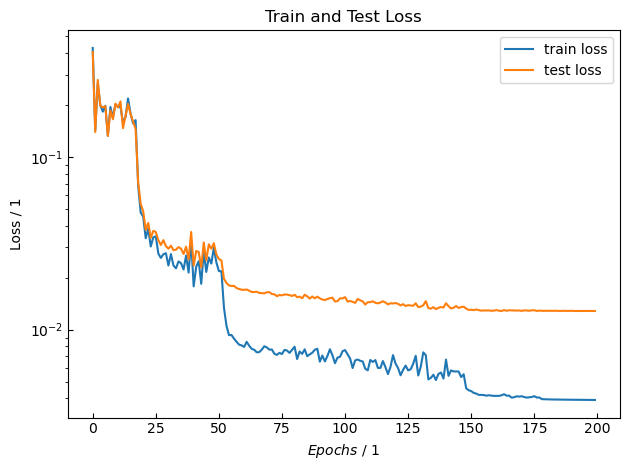

In [10]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.semilogy(train_loss, label='train loss')
ax.semilogy(test_loss, label='test loss')
plt.title("Train and Test Loss")
ax.set(xlabel = '$Epochs$ / 1', ylabel = 'Loss / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Parity Plot

Training Dataset: R^2(H2) = 0.9999086373769364 , R^2(NH3) = 0.999918947776758
Test Dataset: R^2(H2) = 0.9997980584939564 , R^2(NH3) = 0.9995804308885847
Max Error Training: |x_H2 - x_H2,pred| = 0.03995767915005399 , |x_NH3 - x_NH3,pred| = 0.009468485867676762
Max Error Test: |x_H2 - x_H2,pred| = 0.008604933582394503 , |x_NH3 - x_NH3,pred| = 0.010202141057428393


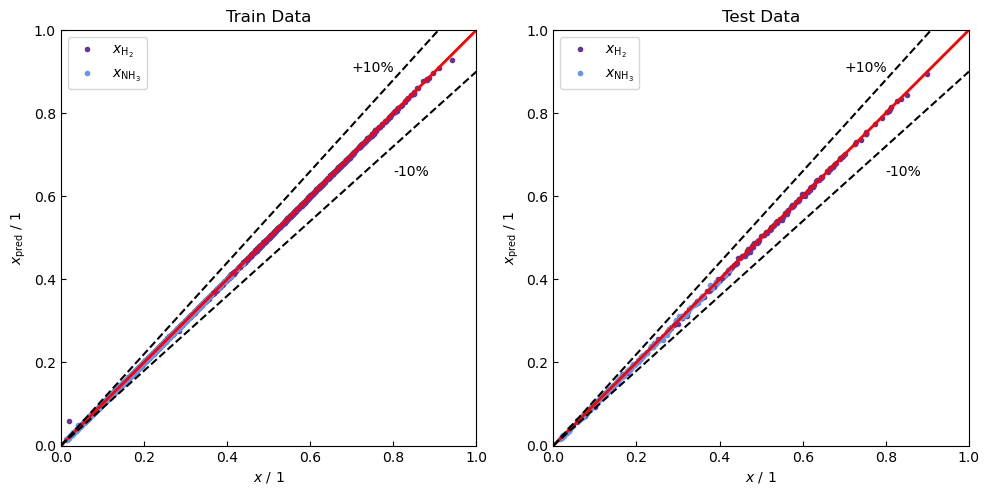

In [11]:
x_H2_real_norm = []
x_H2_pred_norm = []
x_NH3_real_norm = []
x_NH3_pred_norm = []
for (X,y) in train_dataloader:
    x_H2_real_norm = np.append(x_H2_real_norm, y[:,0].numpy())
    x_NH3_real_norm = np.append(x_NH3_real_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_x_H2)
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_x_NH3)

x_H2_real_test_norm = []
x_H2_pred_test_norm = []
x_NH3_real_test_norm = []
x_NH3_pred_test_norm = []
for (X,y) in test_dataloader:
    x_H2_real_test_norm = np.append(x_H2_real_test_norm, y[:,0].numpy())
    x_NH3_real_test_norm = np.append(x_NH3_real_test_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_test_norm = np.append(x_H2_pred_test_norm, help_x_H2)
    x_NH3_pred_test_norm = np.append(x_NH3_pred_test_norm, help_x_NH3)

x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()

x_H2_real_test = x_H2_real_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred_test = x_H2_pred_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real_test = x_NH3_real_test_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred_test = x_NH3_pred_test_norm * std_out[1].numpy() + mean_out[1].numpy()

print('Training Dataset: R^2(H2) =', r2(x_H2_real,x_H2_pred), ', R^2(NH3) =', r2(x_NH3_real,x_NH3_pred))
print('Test Dataset: R^2(H2) =', r2(x_H2_real_test,x_H2_pred_test), ', R^2(NH3) =', r2(x_NH3_real_test,x_NH3_pred_test))
print('Max Error Training: |x_H2 - x_H2,pred| =', max_error(x_H2_real, x_H2_pred), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real, x_NH3_pred))
print('Max Error Test: |x_H2 - x_H2,pred| =', max_error(x_H2_real_test, x_H2_pred_test), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real_test, x_NH3_pred_test))

# find the boundaries of X and Y values
bounds = (0,1)

fig,ax = plt.subplots(1,2, figsize =(10,10))

# # Reset the limits
# ax[0] = plt.gca()
ax[0].set_xlim(bounds)
ax[0].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[0].set_aspect("equal", adjustable="box")

ax[0].plot(x_H2_real, x_H2_pred, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[0].plot(x_NH3_real, x_NH3_pred, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[0].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[0].transAxes)
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[0].text(0.7, 0.9, '+10%')
ax[0].text(0.8, 0.65, '-10%')
ax[0].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].set_title('Train Data')
ax[0].legend()
#ax[0].legend(['$\\mathregular{R^2}$ = ', r2(xi_real,xi_pred)], markerscale=0)

# Reset the limits
#ax[1] = plt.gca()
ax[1].set_xlim(bounds)
ax[1].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[1].set_aspect("equal", adjustable="box")

ax[1].plot(x_H2_real_test, x_H2_pred_test, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[1].plot(x_NH3_real_test, x_NH3_pred_test, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[1].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[1].transAxes)
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[1].text(0.7, 0.9, '+10%')
ax[1].text(0.8, 0.65, '-10%')
ax[1].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].set_title('Test Data')
ax[1].legend()


#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

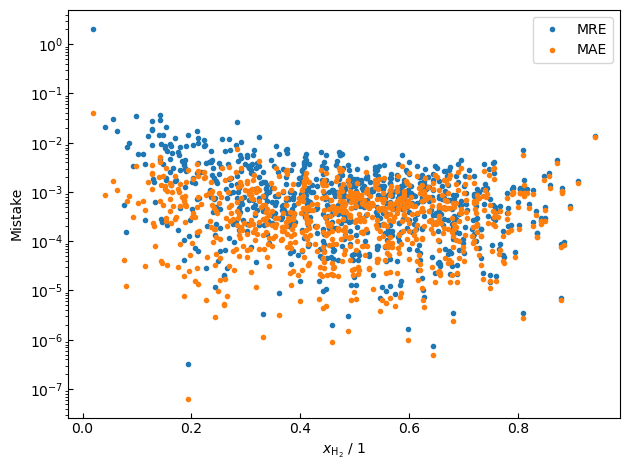

In [12]:
fig,ax = plt.subplots()
ax.semilogy(x_H2_real, abs((x_H2_pred - x_H2_real) / x_H2_real), '.', label = 'MRE')
ax.semilogy(x_H2_real, abs(x_H2_real-x_H2_pred), '.', label = 'MAE')
ax.set(xlabel = '$x \mathregular{_{H_2}}$ / 1', ylabel = 'Mistake')
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Plot Fehler vs Epoch

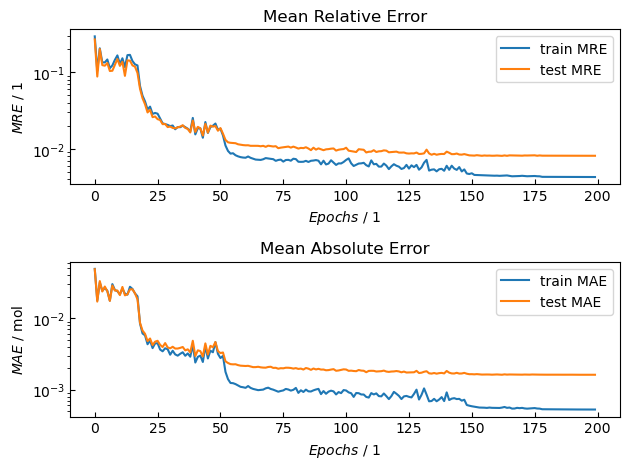

In [13]:
fig,ax = plt.subplots(2)
#fig.figsize=(12, 8)
ax[0].semilogy(train_MRE, label='train MRE')
ax[0].semilogy(test_MRE, label='test MRE')
ax[0].set_title("Mean Relative Error")
ax[0].set(xlabel = '$Epochs$ / 1', ylabel = '$MRE$ / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].legend()

ax[1].semilogy(train_MAE, label='train MAE')
ax[1].semilogy(test_MAE, label='test MAE')
ax[1].set_title("Mean Absolute Error")
ax[1].set(xlabel = '$Epochs$ / 1', ylabel = '$MAE$ / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].legend()

plt.tight_layout()
plt.show()

#### Plot Loss vs Variable Properties

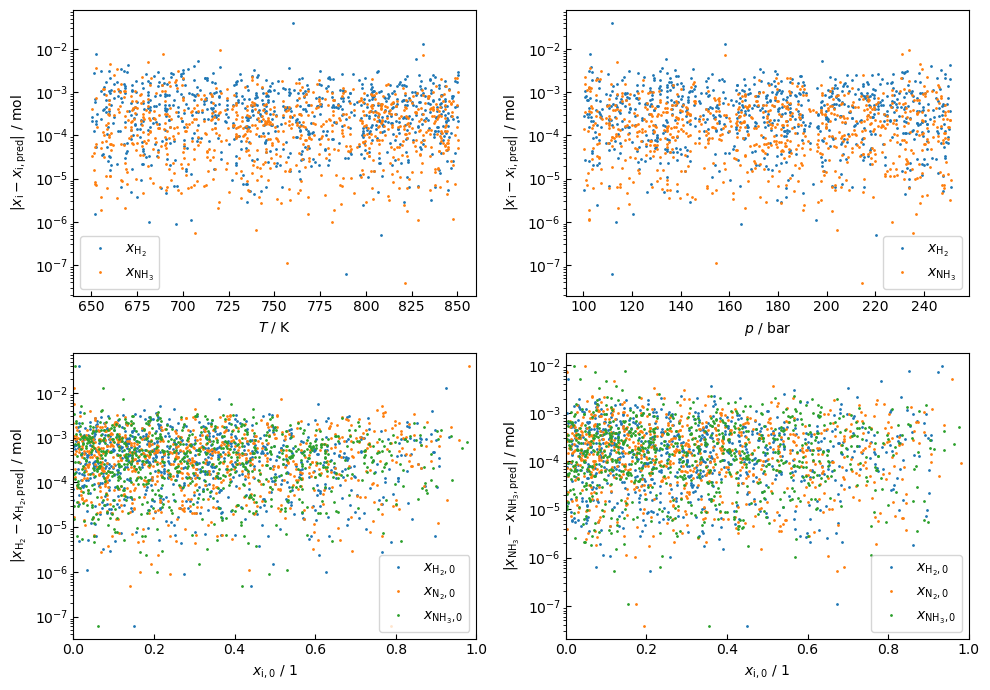

In [14]:
# mistake_H2 = []
# mistake_NH3 = []
x_H2_pred_norm = []
x_NH3_pred_norm = []
x_H2_real_norm = []
x_NH3_real_norm = []
param_T_norm = []
param_p_norm = []
param_x_H2_0_norm = []
param_x_N2_0_norm = []
param_x_NH3_0_norm = []
for X,y in train_dataloader:
#     help_mistake_H2, help_mistake_NH3 = (abs(y - net(X).detach().numpy())).T
#     mistake_H2 = np.append(mistake_H2, help_mistake_H2)
#     mistake_NH3 = np.append(mistake_NH3, help_mistake_NH3
    help_pred = net(X).detach().numpy()
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_pred[:,0])
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_pred[:,1])
    help_real = y.detach().numpy()
    x_H2_real_norm = np.append(x_H2_real_norm, help_real[:,0])
    x_NH3_real_norm = np.append(x_NH3_real_norm, help_real[:,1])
    param_T_norm = np.append(param_T_norm, X[:,0])
    param_p_norm = np.append(param_p_norm, X[:,1])
    param_x_H2_0_norm = np.append(param_x_H2_0_norm, X[:,2])
    param_x_N2_0_norm = np.append(param_x_N2_0_norm, X[:,3])
    param_x_NH3_0_norm = np.append(param_x_NH3_0_norm, X[:,4])

# print('x_H2:', x_H2_real_norm) #, x_H2_real_norm.dtype())
# print('x_H2_pred:', x_H2_pred_norm)
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()

mistake_H2 = abs(x_H2_real - x_H2_pred)
mistake_NH3 = abs(x_NH3_real - x_NH3_pred)

param_T = param_T_norm * std_in[0].numpy() + mean_in[0].numpy()
param_p = param_p_norm * std_in[1].numpy() + mean_in[1].numpy()
param_x_H2_0 = param_x_H2_0_norm * std_in[2].numpy() + mean_in[2].numpy()
param_x_N2_0 = param_x_N2_0_norm * std_in[3].numpy() + mean_in[3].numpy()
param_x_NH3_0 = param_x_NH3_0_norm * std_in[4].numpy() + mean_in[4].numpy()

# print('T:', param_T[0])
# print(len(param_T))
# print(param_T[0])

fig,ax = plt.subplots(2,2, figsize = (10, 7)) #gridspec_kw={'width_ratios': [1,1,1,1]})

ax[0,0].semilogy(param_T, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,0].semilogy(param_T, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,0].set(xlabel = '$T$ / K', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,0].legend()

ax[0,1].semilogy(param_p, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,1].semilogy(param_p, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,1].set(xlabel = '$p$ / bar', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,1].legend()

ax[1,0].semilogy(param_x_H2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,0].semilogy(param_x_N2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,0].semilogy(param_x_NH3_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,0].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{H_2}} - x\mathregular{_{H_2,pred}}$| / mol')
ax[1,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,0].set(xlim = (0,1))
ax[1,0].legend()

ax[1,1].semilogy(param_x_H2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,1].semilogy(param_x_N2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,1].semilogy(param_x_NH3_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,1].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{NH_3}} - x\mathregular{_{NH_3,pred}}$| / mol')
ax[1,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,1].set(xlim = (0,1))
ax[1,1].legend()

plt.tight_layout()
plt.show()

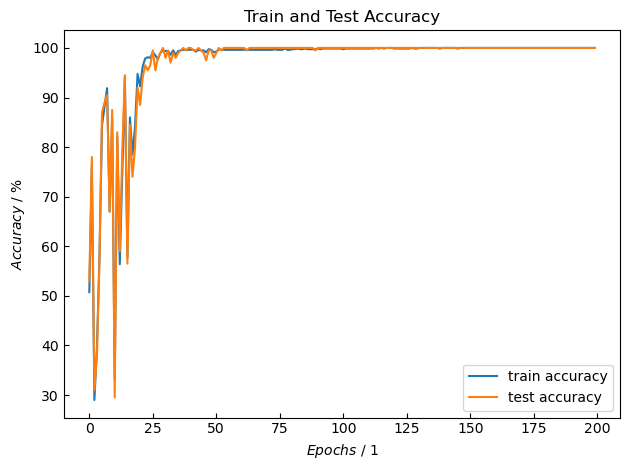

In [15]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_accuracy, label='train accuracy')
ax.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$Accuracy$ / %') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Debugging Hilfe

In [16]:
# Anzeigen aller Input X und Output y Daten
for (X,y) in train_dataloader:
    print(X)
    print(y)
    print(net(X))
    break

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.
tensor([[-0.6428, -0.1032, -0.9699,  0.3975,  0.5456],
        [ 0.6812, -0.9397, -0.9280,  1.6291, -0.7543],
        [-1.4594,  1.2893, -0.1086,  0.2232, -0.1216],
        [ 1.5341, -0.6873,  2.3952, -0.9884, -1.3404],
        [ 0.3586,  0.9616,  1.5749, -1.0438, -0.4787],
        [ 1.6185,  1.2815,  0.0764,  1.0351, -1.1329],
        [-1.2618, -1.5746, -0.2282,  0.1390,  0.0818],
        [-0.3397, -0.2844, -0.6993, -0.3860,  1.0807],
        [ 0.2799, -0.4390, -0.1379, -1.0928,  1.2523],
        [-0.4461, -1.2031, -1.4157,  2.1154, -0.7728],
        [ 0.0511,  0.2952,  2.1183, -1.1227, -0.9314],
        [-0.0369, -1.5949, -0.0789, -1.1470,  1.2498],
        [-0.9857,  0.7669,  1.4802, -0.3404, -1.1048],
        [-1.1767,  0.9620,  1.4423, -1.2923, -0.0947],
        [ 0.9944,  1.4025,  1.3257, -0.7635, -0.5206],
        [ 1.5115, -0.6785, -0.6933, -1.

#### Einblick in Netzwerk

In [17]:
list(net.parameters()) # zeigt weights, biases, ...

[Parameter containing:
 tensor([[ 0.3544, -0.1326, -0.0404, -0.0944, -0.0676],
         [-0.1638,  0.1797, -0.3271, -0.3724, -0.0826],
         [-0.3278, -0.3015,  0.1237, -0.4190,  0.3816],
         [-0.3325,  0.5147,  0.0643,  0.1018, -0.0211],
         [-0.0110,  0.0787,  0.3474,  0.0282,  0.3232],
         [-0.1937,  0.0152, -0.2293,  0.3260, -0.2160],
         [ 0.2190,  0.0109, -0.1884,  0.1018, -0.3617],
         [ 0.3425, -0.2402, -0.0193,  0.2774,  0.1403],
         [-0.1008,  0.1125,  0.0640, -0.2689,  0.2683],
         [ 0.1789, -0.1276,  0.0782, -0.3919, -0.1889],
         [ 0.1776,  0.2247, -0.0597,  0.4102,  0.2118],
         [-0.3971, -0.0927, -0.2260, -0.0424, -0.2486],
         [-0.0634, -0.0283,  0.2042, -0.0348,  0.1117],
         [-0.3065,  0.1278,  0.2130,  0.1397,  0.4309],
         [-0.2431, -0.1794, -0.0849,  0.4649,  0.1198],
         [-0.3930,  0.2007, -0.1002,  0.3332, -0.1488],
         [-0.3123,  0.0223, -0.1375,  0.5152, -0.1468],
         [-0.1657,  0.166

In [18]:
X = torch.rand((2,5))
print(X)
print(net(X))

tensor([[0.3352, 0.0662, 0.7949, 0.8074, 0.9489],
        [0.1978, 0.8929, 0.4184, 0.6665, 0.6562]])
tensor([[ 0.1438,  0.0316],
        [-0.1137,  0.2531]], grad_fn=<AddmmBackward0>)


In [19]:
Lnorm = nn.LayerNorm(5)
Bnorm = nn.BatchNorm1d(5)

In [20]:
for (X,y) in train_dataloader:
    print(X)
    #print(y.reshape((-1,1)))
    print(Bnorm(X).mean(dim=0))
    print(Bnorm(X))
    print(Lnorm(X))
    print((Lnorm(X.permute(0,2,1))).permute(0,2,1))
    print(Lnorm(X).mean(dim=0))
    print(Lnorm(X).mean(dim=1))


    break

tensor([[-0.4044, -0.8176,  0.0219,  0.8257, -0.8654],
        [ 1.4124,  0.5617,  2.2479, -1.0994, -1.0824],
        [-1.1962, -0.8370, -0.9280, -0.9089,  1.8397],
        [-1.0963,  1.4259, -0.4281, -0.3278,  0.7552],
        [ 1.5547,  1.3097, -0.3148,  1.4720, -1.1955],
        [-1.1636,  0.2135,  0.0440,  0.0388, -0.0829],
        [-0.7967,  0.7767,  2.4775, -1.1109, -1.2959],
        [-0.1515, -0.2196, -1.3450,  2.0374, -0.7625],
        [-1.2439,  0.6757, -0.7309, -1.0059,  1.7455],
        [-1.6077,  1.6608, -0.6660,  0.9604, -0.3280],
        [ 1.2701,  0.2183,  1.4775, -0.8387, -0.5929],
        [-1.5183, -0.0111,  1.4100, -0.0813, -1.3006],
        [ 0.0412, -0.7294,  0.1491, -0.1306, -0.0129],
        [-1.2516,  0.5024, -1.3103,  0.0430,  1.2420],
        [-1.3302, -0.9493,  0.2681, -1.2327,  0.9968],
        [ 0.8406, -0.7978, -0.5431,  1.7401, -1.2455],
        [ 1.5021,  0.2814, -1.3550,  0.7836,  0.5289],
        [ 0.1285, -1.3181, -0.8661, -0.9336,  1.8042],
        [ 

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 2 is not equal to len(dims) = 3

#### Histogramme Verteilung von $xi$ und $x{_i}$

In [ ]:
#plt.hist(xi)
plt.hist(x_0[:,0],bins=100)
plt.hist(x_0[:,1],bins=100)

plt.show()